In [1]:
import tensorflow as tf
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import os

2025-04-11 11:20:48.904930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744363249.036776    1027 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744363249.072552    1027 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744363249.373523    1027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744363249.373571    1027 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744363249.373573    1027 computation_placer.cc:177] computation placer alr

In [2]:
def default_crop_region(image_height, image_width):
    """Defines the default crop region

    The function provides the initial crop region (pads the full image from both
    sides to make it a square image) when the algorithm cannot reliably determine
    the crop region from the previous frame.
    """
    
    if image_width > image_height:
        box_height = image_width / image_height
        box_width = 1.0
        y_min = (image_height/2 - image_width/2) / image_height
        x_min = 0.0
    else:
        box_height = 1.0
        box_width = image_height/image_width
        y_min = 0.0
        x_min = (image_width/2 - image_height/2) / image_width
    
    return {'y_min': y_min,
            'x_min': x_min,
            'y_max': y_min + box_height,
            'x_max': x_min + box_width,
            'height': box_height,
            'width': box_width}

In [3]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Minimum confidence score for a keypoint to be considered reliable
MIN_SCORE = 0.2 
def torso_visible(keypoints):
    """Checks if the torso is visible in the keypoints.
    
    The torso is considered visible there are at least one shoulder and one hip
    visible.
    """
    return ((keypoints[0,0,KEYPOINT_DICT['left_hip'      ],2] > MIN_SCORE or
             keypoints[0,0,KEYPOINT_DICT['right_hip'     ],2] > MIN_SCORE) and
            (keypoints[0,0,KEYPOINT_DICT['left_shoulder' ],2] > MIN_SCORE or
             keypoints[0,0,KEYPOINT_DICT['right_shoulder'],2] > MIN_SCORE))

def max_distance(keypoints, target_keypoints, center_y, center_x):
    """Calculates the maximum distance from each keypoints to the center location"""

    torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
    max_torso_ydistance = 0.0
    max_torso_xdistance = 0.0
    for joint in torso_joints:
        dist_y = abs(center_y - target_keypoints[joint][0])
        dist_x = abs(center_x - target_keypoints[joint][1])
        if dist_y > max_torso_ydistance:
            max_torso_ydistance = dist_y
        if dist_x > max_torso_xdistance:
            max_torso_xdistance = dist_x

    max_body_ydistance = 0.0
    max_body_xdistance = 0.0
    for joint in KEYPOINT_DICT.keys():
        if keypoints[0,0,KEYPOINT_DICT[joint],2] < MIN_SCORE:
            continue
        dist_y = abs(center_y - target_keypoints[joint][0])
        dist_x = abs(center_x - target_keypoints[joint][1])
        if dist_y > max_body_ydistance:
            max_body_ydistance = dist_y
        if dist_x > max_body_xdistance:
            max_body_xdistance = dist_x

    return [max_torso_ydistance, max_torso_xdistance,
            max_body_ydistance, max_body_xdistance]

def calculate_crop_region(keypoints, image_height, image_width):
    target_keypoints = {}
    for joint in KEYPOINT_DICT.keys():
        target_keypoints[joint] = [keypoints[0,0,KEYPOINT_DICT[joint],0] * image_height,
                                   keypoints[0,0,KEYPOINT_DICT[joint],1] * image_width]
    
    if not torso_visible(keypoints):
        return default_crop_region(image_height, image_width)
    
    center_y = (target_keypoints['left_hip'][0] + target_keypoints['right_hip'][0]) / 2
    center_x = (target_keypoints['left_hip'][1] + target_keypoints['right_hip'][1]) / 2

    max_ty, max_tx, max_by, max_bx = max_distance(keypoints, target_keypoints, center_y, center_x) 

    half_crop_length = np.amax([max_tx*1.9, max_ty*1.9, max_by*1.2, max_bx*1.2])

    tmp = np.array([center_x, image_width-center_x, center_y, image_height-center_y])
    half_crop_length = np.amin([half_crop_length, np.amax(tmp)])

    crop_corner = [center_y - half_crop_length, center_x - half_crop_length]

    if half_crop_length > max(image_width, image_height) / 2:
        return default_crop_region(image_height, image_width)

    return {'y_min': crop_corner[0] / image_height,
            'x_min': crop_corner[1] / image_width,
            'y_max': (crop_corner[0] + 2*half_crop_length) / image_height,
            'x_max': (crop_corner[1] + 2*half_crop_length) / image_width,
            'height': 2*half_crop_length / image_height,
            'width':  2*half_crop_length / image_width}


In [4]:
model_path = "movenet_lightning"
input_size = 192

if os.path.exists(model_path):
    module = tf.saved_model.load(model_path)
else:
    import tensorflow_hub as hub
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    # tf.saved_model.save(module, model_path)

def model(image):
    model = module.signatures['serving_default']
    image = tf.cast(image, tf.int32)    #SavedModel expects uint8 tensors
    outputs = model(image)
    keypoints_with_scores = outputs['output_0'].numpy()
    
    return keypoints_with_scores


I0000 00:00:1744363258.257549    1027 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2861 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [6]:
# def crop_and_resize(image, crop_region, crop_size):
#   """Crops and resize the image to prepare for the model input."""
#   boxes=[[crop_region['y_min'], crop_region['x_min'],
#           crop_region['y_max'], crop_region['x_max']]]
#   output_image = tf.image.crop_and_resize(
#       image, box_indices=[0], boxes=boxes, crop_size=crop_size)
#   return output_image

In [7]:
def run_inference(model, image, crop_region, crop_size):
    h, w, _ = image.shape

    # Crop the image
    # image = crop_and_resize(tf.expand_dims(image, axis=0), crop_region, crop_size)
    boxes = [[crop_region['y_min'], crop_region['x_min'], crop_region['y_max'], crop_region['x_max']]]
    image = tf.image.crop_and_resize(tf.expand_dims(image,0), boxes, [0], crop_size)

    # Run inference
    keypoints = model(image)    #keypoints_with_scores

    # Change coordinates to original image
    for i in range(17):
        # keypoints[0,0,i,0] = crop_region['y_min'] + crop_region['height'] * keypoints[0, 0, i, 0]
        # keypoints[0,0,i,1] = crop_region['x_min'] + crop_region['width'] * keypoints[0, 0, i, 1]
        keypoints[0,0,i,0] = (crop_region['y_min']*h + crop_region['height']*h*keypoints[0,0,i,0]) / h
        keypoints[0,0,i,1] = (crop_region['x_min']*w + crop_region['width'] *w*keypoints[0,0,i,1]) / w

    return keypoints

The following cell contains drawing function that I did not modify at all.
Mayebe it needs to be looked at to make thing faster or to personalize something

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import LineCollection


# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',    # nose       - L eye
    (0, 2): 'c',    # nose       - R eye
    (1, 3): 'm',    # L eye      - L ear
    (2, 4): 'c',    # R eye      - R ear
    (0, 5): 'm',    # nose       - L shoulder
    (0, 6): 'c',    # nose       - R shoulder
    (5, 7): 'm',    # L shoulder - L elbow
    (7, 9): 'm',    # L elbow    - L wrist
    (6, 8): 'c',    # R shoulder - R elbow
    (8, 10): 'c',   # R elbow    - R wrist
    (5, 6): 'y',    # L shoulder - R shoulder
    (5, 11): 'm',   # L shoulder - L hip
    (6, 12): 'c',   # R shoulder - R hip
    (11, 12): 'y',  # L hip      - R hip
    (11, 13): 'm',  # L hip      - L knee
    (13, 15): 'm',  # L knee     - L ankle
    (12, 14): 'c',  # R hip      - R knee
    (14, 16): 'c'   # R knee     - R ankle
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors

def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

In [171]:
video_path = '123.mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video file: {video_path}")
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

crop_region = default_crop_region(height, width)

frame_num = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    keypoints_with_scores = run_inference(model, frame, crop_region, [input_size, input_size])
    frame = draw_prediction_on_image(frame, 
                                     keypoints_with_scores, 
                                     crop_region=None, 
                                     close_figure=True, 
                                     output_image_height=1080)   #Lower quality for faster processing
    
    # Write the frame number on the image
    cv2.putText(frame, f'Frame: {frame_num}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    crop_region = calculate_crop_region(keypoints_with_scores, height, width)
    
    cv2.imshow('frame', frame)
    if cv2.waitKey() & 0xFF == ord('q'):
        break
    frame_num += 1
    
cap.release()
cv2.destroyAllWindows()

In [148]:
# Save all the prediction to a np.array (shape [frames, 17, 3])

keypoints = np.zeros((0, 17, 3))

video_path = '123.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video file: {video_path}")
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
crop_region = default_crop_region(height, width)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    keypoints_with_scores = run_inference(model, frame, crop_region, [input_size, input_size])
    keypoints = np.append(keypoints, keypoints_with_scores[0,0,:,:].reshape(1,17,3), axis=0)
    
    crop_region = calculate_crop_region(keypoints_with_scores, height, width)
cap.release()
np.save('keypoints.npy', keypoints)


In [149]:
test = np.load('keypoints.npy')

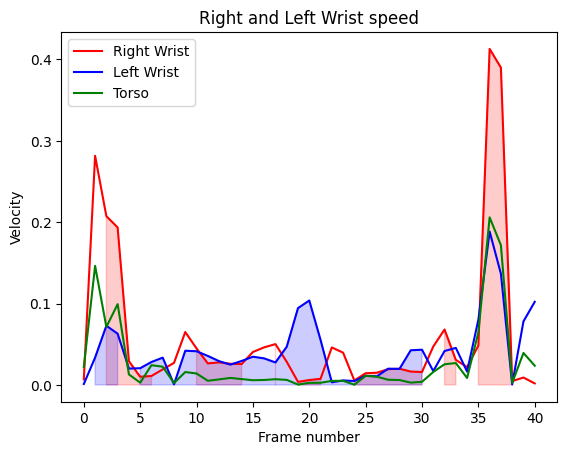

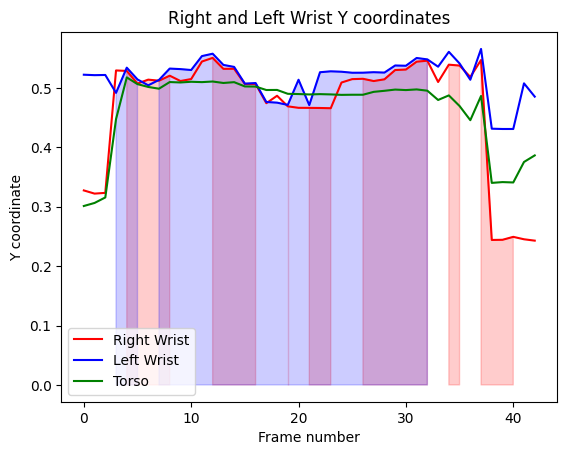

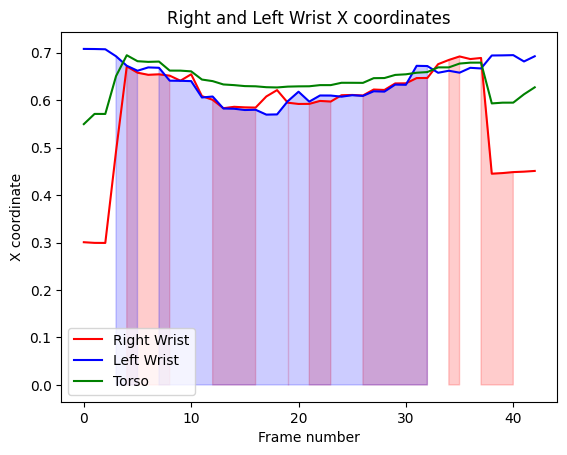

In [154]:
right_wrist = test[:,KEYPOINT_DICT['right_wrist'],:]
left_wrist = test[:,KEYPOINT_DICT['left_wrist'],:]

# get the middle point of the torso (between the shoulders and hips)
torso = (test[:,KEYPOINT_DICT['left_shoulder'],:] + test[:,KEYPOINT_DICT['right_shoulder'],:] +
         test[:,KEYPOINT_DICT['left_hip'],:] + test[:,KEYPOINT_DICT['right_hip'],:]) / 4

delta = 2

# Plot the module of the velocity of the wrists and torso
plt.plot(np.sqrt(np.square(np.diff(right_wrist[:,0],delta)) + np.square(np.diff(right_wrist[:,1],delta))), 'r')
plt.plot(np.sqrt(np.square(np.diff(left_wrist[:,0],delta)) + np.square(np.diff(left_wrist[:,1],delta))), 'b')
plt.plot(np.sqrt(np.square(np.diff(torso[:,0],delta)) + np.square(np.diff(torso[:,1],delta))), 'g')
plt.title('Right and Left Wrist speed')
plt.xlabel('Frame number')
plt.ylabel('Velocity')
plt.legend(['Right Wrist', 'Left Wrist', 'Torso'])
# plt.fill_between(range(len(right_wrist)-1), 0, np.sqrt(np.square(np.diff(right_wrist[:,0])) + np.square(np.diff(right_wrist[:,1]))), where=right_wrist[1:,2]>MIN_SCORE, color='red', alpha=0.2)
plt.fill_between(range(len(right_wrist)-delta), 0, np.sqrt(np.square(np.diff(right_wrist[:,0],delta)) + np.square(np.diff(right_wrist[:,1],delta))), where=right_wrist[delta:,2]>MIN_SCORE, color='red', alpha=0.2)
plt.fill_between(range(len(left_wrist)-delta), 0, np.sqrt(np.square(np.diff(left_wrist[:,0],delta)) + np.square(np.diff(left_wrist[:,1],delta))), where=left_wrist[delta:,2]>MIN_SCORE, color='blue', alpha=0.2)
# plt.fill_between(range(len(torso)-1), 0, np.sqrt(np.square(np.diff(torso[:,0])) + np.square(np.diff(torso[:,1]))), where=torso[1:,2]>MIN_SCORE, color='green', alpha=0.2)
plt.show()

# Plot the y coordinates of the velocity of the wrists and torso
# plt.plot(np.diff(right_wrist[:,0],delta), 'r')
# plt.plot(np.diff(left_wrist[:,0],delta), 'b')
# plt.plot(np.diff(torso[:,0],delta), 'g')
# plt.title('Right and Left Wrist Y velocity')
# plt.xlabel('Frame number')
# plt.ylabel('Y velocity')
# plt.legend(['Right Wrist', 'Left Wrist', 'Torso'])
# graph_min = min(np.diff(right_wrist[:,0],delta).min(), np.diff(left_wrist[:,0],delta).min())
# plt.fill_between(range(len(right_wrist)-delta), graph_min, np.diff(right_wrist[:,0],delta), where=right_wrist[delta:,2]>MIN_SCORE, color='red', alpha=0.2)
# plt.fill_between(range(len(left_wrist)-delta), graph_min, np.diff(left_wrist[:,0],delta), where=left_wrist[delta:,2]>MIN_SCORE, color='blue', alpha=0.2)
# plt.fill_between(range(len(torso)-delta), 0, np.diff(torso[:,0],delta), where=torso[delta:,2]>MIN_SCORE, color='green', alpha=0.2)
# plt.show()

# Plot wrists and torso Y coordinates over time
plt.plot(right_wrist[:,0], 'r')
plt.plot(left_wrist[:,0], 'b')
plt.plot(torso[:,0], 'g')
plt.title('Right and Left Wrist Y coordinates')
plt.xlabel('Frame number')
plt.ylabel('Y coordinate')
plt.legend(['Right Wrist', 'Left Wrist', 'Torso'])
plt.fill_between(range(len(right_wrist)), 0, right_wrist[:,0], where=right_wrist[:,2]>MIN_SCORE, color='red', alpha=0.2)
plt.fill_between(range(len(left_wrist)), 0, left_wrist[:,0], where=left_wrist[:,2]>MIN_SCORE, color='blue', alpha=0.2)
# plt.fill_between(range(len(torso)), 0, torso[:,0], where=torso[:,2]>MIN_SCORE, color='green', alpha=0.2)
plt.show()

# Plot wrists and torso X coordinates over time
plt.plot(right_wrist[:,1], 'r')
plt.plot(left_wrist[:,1], 'b')
plt.plot(torso[:,1], 'g')
plt.title('Right and Left Wrist X coordinates')
plt.xlabel('Frame number')
plt.ylabel('X coordinate')
plt.legend(['Right Wrist', 'Left Wrist', 'Torso'])
plt.fill_between(range(len(right_wrist)), 0, right_wrist[:,1], where=right_wrist[:,2]>MIN_SCORE, color='red', alpha=0.2)
plt.fill_between(range(len(left_wrist)), 0, left_wrist[:,1], where=left_wrist[:,2]>MIN_SCORE, color='blue', alpha=0.2)
# plt.fill_between(range(len(torso)), 0, torso[:,1], where=torso[:,2]>MIN_SCORE, color='green', alpha=0.2)
plt.show()

Perform classification

In [166]:
import numpy as np

def classify_shot(right_wrist, left_wrist, torso,
                  left_handed=False, 
                  shot_frame=None,
                  visibility=0.2, 
                  percentage=0.8, 
                  alpha=0.8,
                  max_torso_speed=10.0, 
                  min_wrist_speed=0.0, 
                  min_wrist_velocity=[0.0, 0.0],
                  frame_window_x=[5, 10],
                  frame_window_y=[1, 2]):
    """
    Classify the padel shot type based on temporal keypoint data.
    Parameters
    ----------
    right_wrist : np.ndarray
        Array of shape (N, 3) containing the right wrist keypoints.
    left_wrist : np.ndarray
        Array of shape (N, 3) containing the left wrist keypoints.
    torso : np.ndarray
        Array of shape (N, 3) containing the torso keypoints.
    left_handed : bool, optional
        If True, the player is left-handed. Default is False (right-handed).
    shot_frame : int, optional
        Frame number where the shot is taken. If None, it will be calculated according to velocity and visibility of the wrist.
    visibility : float, optional
        Minimum confidence/visibility score for a keypoint to be considered valid. Default is 0.2.
    percentage : float, optional
        Minimum percentage of frames with valid keypoints. Default is 0.8.
    alpha : float, optional
        Weighting factor for the confidence in the calculation of shot_frame. Default is 0.8.
    max_torso_speed : float, optional
        Maximum torso speed allowed before considering the player moving too fast. Default is 10.0.
    min_wrist_speed : float, optional
        Minimum wrist speed required to consider the shot valid. Default is 0.0.
    min_wrist_velocity : list, optional
        Minimum wrist velocity in x and y directions to consider the shot valid. Default is [0.0, 0.0].
    frame_window_x : list, optional
        Number of frames before and after the shot frame to consider for x trend analysis. Default is [5, 10].
    frame_window_y : list, optional
        Number of frames before and after the shot frame to consider for y trend analysis. Default is [1, 2].
    
    Returns
    -------
    message : str
        The type of shot classified as "Schiacciata", "Colpo di rovescio", "Colpo di dritto", or "STOP" with a reason.
    """
    

    # RULE 1: Discard frames before an acceptable right wrist (or both wrists)
    valid_rw = np.where(right_wrist[:, 2] > visibility)[0]
    valid_lw = np.where(left_wrist [:, 2] > visibility)[0]
    if valid_rw.size == 0 or valid_lw.size == 0:
        return "STOP: No acceptable right or left wrist detected."
    # start_idx = max(valid_rw[0], valid_lw[0])
    # instead, make start_idx when both wrists are visible at the same time
    valid = np.intersect1d(valid_rw, valid_lw)
    if valid.size == 0:
        return "STOP: No simultaneous visibility of both wrists."
    start_idx = valid[0]

    print(f"Start index: {start_idx}")
    
    rw = right_wrist[start_idx:]
    lw = left_wrist[start_idx:]
    wrist = lw if left_handed else rw
    torso = torso[start_idx:]
    num_frames = wrist.shape[0]
    
    # RULE 2: Require that a minimum percentage of frames have any required joints visible.

    # Visible_mask is a list of booleans. Calculating the mean gives the fraction of frames
    # where at least one of (if |) or both (if &) the joints is visible.
    # TODO: See if it's better to use both wrists, or just the right, or add the torso
    #       Also, see if considering | or & is better.

    # visible_mask = ((rw[:, 2] > thresh["visibility"]) |
    #                 (lw[:, 2] > thresh["visibility"]) |
    #                 (torso[:, 2] > thresh["visibility"]))
    # visible_mask = (wrist[:, 2] > visibility)
    visible_mask = ((rw[:, 2] > visibility) |
                    (lw[:, 2] > visibility))
    if visible_mask.mean() < percentage:
        return "STOP: Visibility below threshold."
    
    # RULE 3: Compute the right wrist velocity (using differences over delta consecutive frames)
    # TODO: Check if it's better to use torso or wrist speed (or a mean of both / the three)
    delta = 2  # Number of frames to consider for velocity calculation
    wrist_positions = wrist[:, :2]  # (N, 2)            # Use only the x, y coordinates and compute a vectorized difference
    wrist_vel = np.diff(wrist_positions, delta, axis=0) # Drops last delta elements (with delta=1, out = [a[1] - a[0], a[2] - a[1], ...])
    wrist_vel_x = wrist_vel[:, 0]  # (N-2, 2)
    wrist_vel_y = wrist_vel[:, 1]  # (N-2, 2)
    wrist_speed = np.linalg.norm(wrist_vel, axis=1)     # Speed is the Euclidean norm of the difference
    
    # If the frame where the shot is taken is not provided, it needs to be 
    # calculated based on the maximum velocity of the wrist on visible frames.
    if shot_frame is None:
        # score is the weighted mean of the speed and the visibility
        # TODO: Check if it's better to include the other wrist and/or the torso
        window_size = 1
        confidence_avg = np.convolve(wrist[:, 2], np.ones(window_size)/window_size, mode='valid')

        # truncate the confidence to the same size as the speed
        confidence_avg = confidence_avg[:len(wrist_speed)]
        # TODO: If it happens that the confidence is smaller than the speed,
        #       then what it needs to be done is:
        # valid_length = min(len(wrist_speed), len(confidence_avg))
        # valid_speed = wrist_speed[:valid_length]
        # valid_confidence = confidence_avg[:valid_length]
        
        score = wrist_speed * (confidence_avg ** alpha)

        # Equivalent to:
        # w_speed = np.sqrt(np.square(np.diff(rw[:, 0], delta)) + np.square(np.diff(rw[:, 1], delta)))

        # Find the frame with maximum torso movement;
        # TODO: See if I need to add +delta because diff reduces one frame (max_idx corresponds to frame index in original sequence)
        max_idx = np.argmax(score)

        print(f"Max velocity index: {max_idx}")
        print(f"Max score: {score[max_idx]}")
        print(f"Max velocity: {wrist_speed[max_idx]}")
        print(f"Max velocity (confidence): {confidence_avg[max_idx]}")
    else:
        max_idx = shot_frame - start_idx
        num_frames = torso.shape[0]
        wrist = left_wrist if left_handed else right_wrist
        torso = torso

        print(f"Given shot frame: {shot_frame}")
        print(f"Max velocity index: {max_idx}")

    # RULE 4: Check if torso speed is too high or wrist speed is too low
    # (Here we assume thresholds for speed, as well as x and y movement during the max movement frame.)
    torso_speed = np.sqrt(np.square(np.diff(torso[:, 0], delta)) + np.square(np.diff(torso[:, 1], delta)))

    if torso_speed[max_idx] > max_torso_speed:
        return "STOP: Torso speed too high."
    if wrist_speed[max_idx] < min_wrist_speed:
        return "STOP: Wrist speed too low."
    
    print(f"Torso speed: {torso_speed[max_idx]}")
    
    # Additionally, check the individual x and y movements at max moment.
    # (Taking the difference at max_idx - 1; using absolute values to ensure sufficient change)
    
    # TODO: Maybe to remove. This check only the instantaneous velocity
    # at the max moment, not the average over the window.
    if (abs(wrist_vel_x[max_idx]) < min_wrist_velocity[0] or 
        abs(wrist_vel_y[max_idx]) < min_wrist_velocity[1]):
        print ("STOP: Insufficient instantaneous movement in x or y direction.")
    
    print(f"Wrist velocity y: {wrist_vel_y[max_idx]}")
    print(f"Wrist velocity x: {wrist_vel_x[max_idx]}")
    
    # RULE 5: Analyze the y trend within a window around max_idx
    start_y = max(0, max_idx - frame_window_y[0])
    end_y = min(num_frames, max_idx + frame_window_y[1])
    start_x = max(0, max_idx - frame_window_x[0])
    end_x = min(num_frames, max_idx + frame_window_x[1])

    print(f"Start y: {start_y}, End y: {end_y}")
    print(f"Start x: {start_x}, End x: {end_x}")

    # TODO: Remove, just for debugging
    #       Also, move start_x end_x inside the if below (to avoid unnecessary calculations)
    if start_y == 0:
        print("Warning: start_y is 0")
    if end_y == num_frames:
        print("Warning: end_y is num_frames")
    if start_x == 0:
        print("Warning: start_x is 0")
    if end_x == num_frames:
        print("Warning: end_x is num_frames")

    # Compute average delta in x and y across the window
    dy = wrist_vel_y[start_y:end_y]

    avg_dy = dy.mean()

    print(dy)
    print(f"Average delta y: {avg_dy}")
    
    # If average delta y is positive, y is increasing (movement from top down) -> Schiacciata.
    # If average delta y is negative, then movement is from bottom up; check x trend.
    # TODO: Change 0 with a threshold

    if avg_dy > min_wrist_velocity[1]:
        return "Schiacciata"  # shot coming from above
    if avg_dy < -min_wrist_velocity[1]:
        # Check x trend in a different (longer) window.
        dx = wrist_vel_x[start_x:end_x]
        avg_dx = dx.mean()

        print(f"Average delta x: {avg_dx}")

        if avg_dx > min_wrist_velocity[0]:
            return "Colpo di rovescio"  # movement left to right
        elif avg_dx < -min_wrist_velocity[0]:
            return "Colpo di dritto"    # movement right to left
        else:
            return "Undetermined shot: x trend ambiguous."
    else:
        return "Undetermined shot: y trend ambiguous."

In [170]:
classify_shot(right_wrist, left_wrist, torso, shot_frame=13, alpha=0.8, min_wrist_velocity=[0.0005, 0.01], max_torso_speed=0.17)

Start index: 4
Given shot frame: 13
Max velocity index: 9
Torso speed: 0.008599794800577248
STOP: Insufficient instantaneous movement in x or y direction.
Wrist velocity y: -0.00416642427444458
Wrist velocity x: -0.02564448118209839
Start y: 8, End y: 11
Start x: 4, End x: 19
[ 0.02065927 -0.00416642  0.00071901]
Average delta y: 0.005737284819285075


'Undetermined shot: y trend ambiguous.'